# Homework


The homework is to prepare a report for the Ministry of Transport, revealing the nature and characteristics of flight delays. The report should help identify problem areas and contribute to decision-making. Therefore, strive not to state general facts, but to show problems. For example, the fact "the average departure delay is 15 minutes" by itself says little and does not help to understand why this is happening. On the contrary, a graph showing that on Mondays delays increase threefold compared to other days against the background of an increase in the number of flights and passengers suggests a possible cause of the problem: airports cannot cope with uneven load.

The report should be in the form of a notebook with a clear structure. At the beginning of the Markdown cell there is a brief description of the question under study (what we will study), then the code and all its outputs (tables, graphs, values), then again in the Markdown cell in which your brief conclusion is formulated.

The report should contain at least **5 results** confirmed by graphs. For variety of material, use different types of diagrams. All graphs should be provided with the necessary signatures (axis designations, title, color scheme legend).

To solve the problems, use the methods of the `pandas` library.

# Сначала подготовим наши данные к использованию

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

flights_df = pd.read_csv('flights.csv', low_memory=False)
airports_df = pd.read_csv('airports.csv', low_memory=False)
airlines_df = pd.read_csv('airlines.csv', low_memory=False)

flights_df.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# проверим NaN
flights_df_mask = flights_df[['DEPARTURE_TIME', 'ARRIVAL_TIME']].isna().any(axis=1)
flights_df = flights_df.loc[~flights_df_mask]

# изменим "DATE"
flights_df['DATE'] = pd.to_datetime(flights_df[['YEAR', 'MONTH', 'DAY']])
flights_df = flights_df.drop(columns=['YEAR', 'MONTH', 'DAY'])

# поставим "DATE" первым столбцом
cols = list(flights_df.columns)
cols[-1:] + cols[:-1]
flights_df = flights_df[cols[-1:] + cols[:-1]]
flights_df.head(10)

# изменим "DAY_OF_WEEK"
day_map = {
    1: 'ПНД',
    2: 'ВТ',
    3: 'СР',
    4: 'ЧТ',
    5: 'ПТ',
    6: 'СБ',
    7: 'ВС'
}
flights_df['DAY_OF_WEEK'] = flights_df['DAY_OF_WEEK'].map(day_map)

# оставим только задержки, без вылетов заранее
delays_flights_df = flights_df[flights_df['DEPARTURE_DELAY'] > 0]

delays_flights_df.head(5)

,DATE,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
7,2015-01-01,ЧТ,US,2013,N584UW,LAX,CLT,30,44.0,14.0,...,753.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,2015-01-01,ЧТ,DL,1173,N826DN,LAS,ATL,30,33.0,3.0,...,656.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
20,2015-01-01,ЧТ,NK,520,N525NK,LAS,MCI,55,120.0,25.0,...,543.0,6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
27,2015-01-01,ЧТ,NK,597,N528NK,MSP,FLL,115,127.0,12.0,...,607.0,25.0,0,0,NaN,25.0,0.0,0.0,0.0,0.0
29,2015-01-01,ЧТ,AA,2392,N3HRAA,DEN,MIA,120,141.0,21.0,...,709.0,2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Рассмотрим задержки вылетов по дням недели

Создадим dataframe's с количеством задержек и количеством всех вылетов и проанализируем

In [13]:
sort_days = list(day_map.values())
grouped_delays_df = delays_flights_df.groupby('DAY_OF_WEEK').size().reset_index(name='DELAY_COUNT')
grouped_delays_df = grouped_delays_df.set_index('DAY_OF_WEEK').reindex(sort_days).reset_index()

grouped_delays_df.head(7)

,DAY_OF_WEEK,DELAY_COUNT
0,ПНД,322731
1,ВТ,295277
2,СР,302589
3,ЧТ,333698
4,ПТ,328375
5,СБ,237645
6,ВС,301018


In [14]:
grouped_all_departures_df =  flights_df.groupby('DAY_OF_WEEK').size().reset_index(name= 'ALL_DEPARTURES')
grouped_all_departures_df = grouped_all_departures_df.set_index('DAY_OF_WEEK').reindex(sort_days).reset_index()

grouped_all_departures_df.head(7)

,DAY_OF_WEEK,ALL_DEPARTURES
0,ПНД,843900
1,ВТ,829227
2,СР,844846
3,ЧТ,859796
4,ПТ,853139
5,СБ,691403
6,ВС,804255


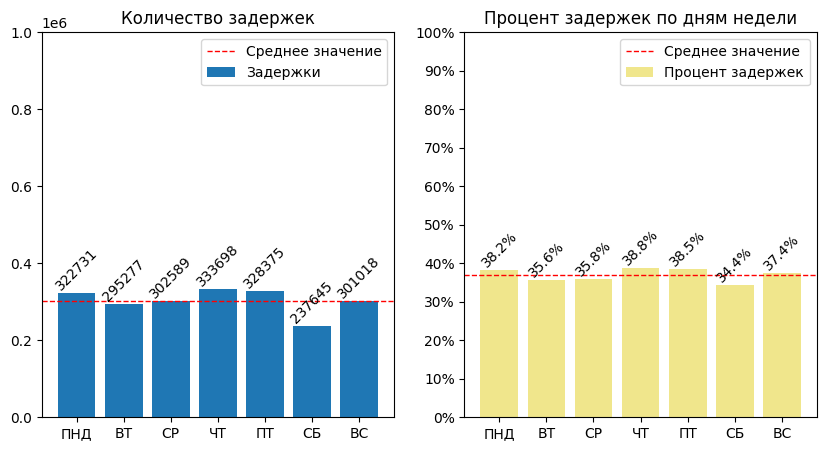

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

#ax1
ax1.bar(sort_days, grouped_delays_df['DELAY_COUNT'], label= 'Задержки')
ax1.set_ylim([0, 1000000])
for i, v in enumerate(grouped_delays_df['DELAY_COUNT']):
    ax1.text(i, v, str(v), ha='center', va='bottom', fontsize=10, rotation= 45)

mean1 = grouped_delays_df['DELAY_COUNT'].mean()
ax1.axhline(y=mean1, color='r', linestyle='--', linewidth=1, label='Среднее значение')

ax1.legend()
ax1.set_title('Количество задержек')

#ax2
delays_percentage = np.array([d / a * 100 for d, a in
zip(grouped_delays_df['DELAY_COUNT'], grouped_all_departures_df['ALL_DEPARTURES'])])

ax2.bar(sort_days, delays_percentage, label= 'Процент задержек', color= 'khaki')
for i, v in enumerate(delays_percentage):
    ax2.text(i, v, f"{v:.1f}%", ha='center', va='bottom', fontsize=10, rotation= 45)

mean2 = delays_percentage.mean()
ax2.axhline(y= mean2, color='r', linestyle='--', linewidth=1, label='Среднее значение')


plt.yticks(range(0,101, 10))
ax2 = plt.gca()
yticks = ax2.get_yticks()
new_labels = [f"{tick}%" for tick in yticks]
ax2.set_yticklabels(new_labels)
ax2.legend()

plt.title('Процент задержек по дням недели')
plt.show()

Видим прямую зависимость между количеством задержек и долей задержек относительно всех рейсов на дню, следовательно проблема задержек не в перегрузе количеством рейсов за день.

Самый проблемный день - четверг, попробуем разобраться в чем проблема.

In [16]:
th_df = delays_flights_df[delays_flights_df['DAY_OF_WEEK'] == 'ЧТ']

Далее будем рассматривать задержки только по четвергам и которые дольше обычного, чтобы разобраться в самых проблемных

In [17]:
th_df = th_df[th_df['DEPARTURE_DELAY'] > th_df['DEPARTURE_DELAY'].quantile(0.75)]

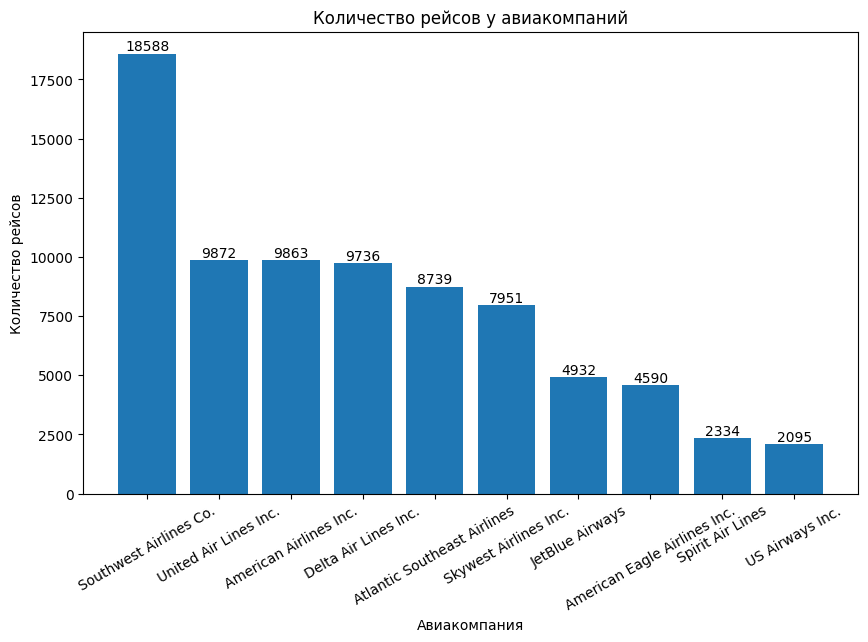

In [32]:
#авикомпании
flights_airlines = pd.merge(th_df, airlines_df, left_on='AIRLINE', right_on='IATA_CODE', how='left')
airlines_delay_df = flights_airlines.groupby('AIRLINE_y').size().sort_values().reset_index(name = 'FLIGHT_COUNT')
top_airlines_delay_df = airlines_delay_df.nlargest(10, 'FLIGHT_COUNT')

plt.figure(figsize=(10, 6))

bars = plt.bar(top_airlines_delay_df['AIRLINE_y'], top_airlines_delay_df['FLIGHT_COUNT'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}',
             ha='center', va='bottom', fontsize=10)

plt.title('Количество рейсов у авиакомпаний')
plt.xlabel('Авиакомпания')
plt.ylabel('Количество рейсов')
plt.xticks(rotation=30)
plt.show()

Видим, что Southwest Airlines Co. имеют наибольшее количество рейсов по четвергам с задержками, длительность которых превышает 75% от общего значения

Посмотрим аэропорты, из которых чаще всего вылетают рейсы этой авиакомпании.

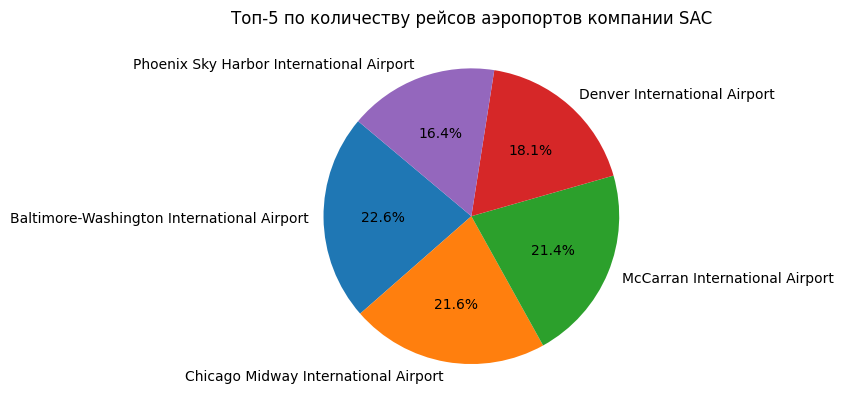

In [58]:
flights_airlines_SAC = flights_airlines[flights_airlines['AIRLINE_y'] == 'Southwest Airlines Co.']
flights_airlines_SAC = pd.merge(flights_airlines_SAC, airports_df, left_on='ORIGIN_AIRPORT', right_on= 'IATA_CODE', how= 'left')

# топ5 по кол-ву рейсов сгруппированные по аэропортам рейсы компании SAC 
top5_grouped_df = flights_airlines_SAC.groupby('AIRPORT').size().sort_values().reset_index(name = 'FLIGHT_COUNT').nlargest(5, 'FLIGHT_COUNT')

plt.pie(top5_grouped_df['FLIGHT_COUNT'], labels=top5_grouped_df['AIRPORT'], autopct='%1.1f%%',
        startangle=140)

plt.title('Топ-5 по количеству рейсов аэропортов компании SAC')

# Показываем график
plt.show()


In [73]:
sairports5 = np.array(top5_grouped_df['AIRPORT'])
filtered_delays_df = flights_airlines_SAC[flights_airlines_SAC['AIRPORT'].isin(airports5)]
filtered_delays_df.head(3)

,DATE,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,WEATHER_DELAY,IATA_CODE_x,AIRLINE_y,IATA_CODE_y,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
7,2015-01-01,ЧТ,WN,701,N419WN,LAS,SAN,935,1020.0,45.0,...,0.0,WN,Southwest Airlines Co.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233
10,2015-01-01,ЧТ,WN,2041,N8317M,LAS,DEN,1005,1046.0,41.0,...,0.0,WN,Southwest Airlines Co.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233
12,2015-01-01,ЧТ,WN,972,N761RR,LAS,LAX,1030,1118.0,48.0,...,0.0,WN,Southwest Airlines Co.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233


Датафрейм выше содержит информацию о рейсах по четвергам компании SAC из пяти самых частых для этой компании аэропортов. Его мы собирали исходя из худших показателей, то есть проанализировав его, мы можем найти причину самых долгих задержек по всем рейсам.

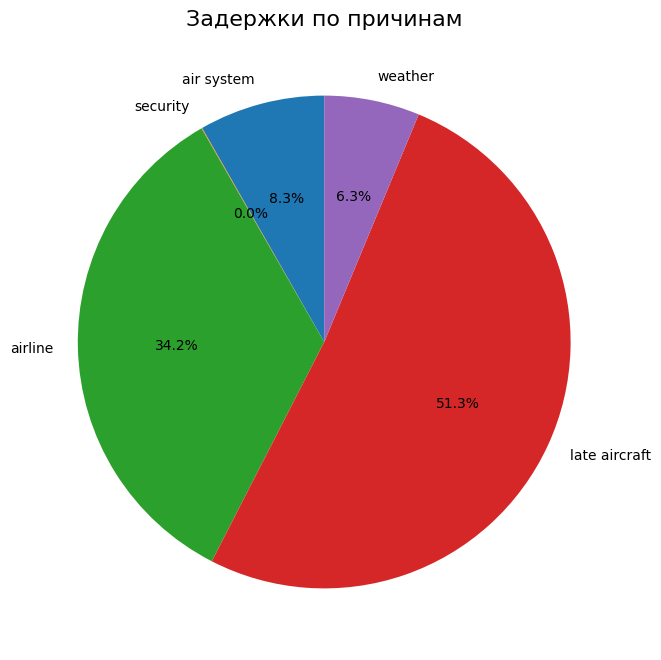

In [72]:
delay_causes = filtered_delays_df[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']].sum()
labels = ['air system', 'security', 'airline', 'late aircraft', 'weather']
plt.figure(figsize=(8, 8))
plt.pie(delay_causes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Задержки по причинам', fontsize=16)
plt.show()

Основной причиной самых длительных задержек действительно снова оказывается задержка самолета, что подтверждает накопительный характер проблем. Это явление особенно заметно, когда небольшие первоначальные задержки накапливаются и приводят к значительным сбоям в графике полетов. Важно учитывать, что подобные задержки могут быть вызваны различными факторами, такими как технические неисправности, неблагоприятные погодные условия или проблемы с организацией

Дальше можно проанализировать эти наиболее длинные задержки компании SAC относительно времени года, погодных условий, городов и выявить цепочку задержек, которые приводят к таким большим